
# SC4002 / CE4045 / CZ4045 NLP — Assignment — Part 3.1: biLSTM

This notebook replaces the simple RNN from Part 2 with a **bidirectional LSTM (biLSTM)** as required in Part 3.1, and logs:
- Training loss per epoch
- Validation accuracy per epoch
- Final **test accuracy** and **topic-wise accuracy**


## Question 3. Enhancement 
(a) (a) Plot the training loss curve and validation accuracy curve of biLSTM and biGRU. Report their
accuracies on the test set (Part 3.1)

In [16]:

import sys, os, math, random, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from collections import Counter, defaultdict

import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(888)



## Data & Vocab Loading from Part 1

In [17]:
# Load previously saved artifacts from Part 1

LOAD_PREPARED = True  
if LOAD_PREPARED:
    bundle = torch.load("trec_artifacts.pt", map_location="cpu")


    TEXT = data.Field(**bundle["text_field_kwargs"])
    LABEL = data.LabelField(**bundle["label_field_kwargs"])

    fields = [("text", TEXT), ("label", LABEL)]

    def rebuild(dataset_blob):
        examples = [
            data.Example.fromlist([item["tokens"], item["label"]], fields)
            for item in dataset_blob
        ]
        return data.Dataset(examples, fields)

    train_data = rebuild(bundle["train_examples"])
    valid_data = rebuild(bundle["valid_examples"])
    test_data  = rebuild(bundle["test_examples"])

    for ds in (train_data, valid_data, test_data):
        ds.sort_key = lambda ex: len(ex.text)

    TEXT.build_vocab([])
    TEXT.vocab.itos = bundle["text_vocab_itos"]
    unk_token = TEXT.unk_token
    if unk_token not in TEXT.vocab.itos:
        raise ValueError("UNK token missing from serialized vocabulary.")
    unk_index = TEXT.vocab.itos.index(unk_token)
    TEXT.vocab.stoi = defaultdict(lambda: unk_index,
                                  {tok: i for i, tok in enumerate(TEXT.vocab.itos)})
    TEXT.vocab.vectors = bundle["text_vocab_vectors"]

    LABEL.build_vocab([])
    LABEL.vocab.itos = bundle["label_vocab_itos"]
    LABEL.vocab.stoi = {tok: i for i, tok in enumerate(LABEL.vocab.itos)}



    pretrained_embeddings = TEXT.vocab.vectors

    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=bundle["batch_size"],
        sort_within_batch=True,
        device=DEVICE,
    )
    print("Artifacts loaded.")

Artifacts loaded.


In [18]:
print(len(TEXT.vocab)
      , len(LABEL.vocab)
      , pretrained_embeddings.size()
     )
VOCAB_SIZE = len(TEXT.vocab)
NUM_CLASSES = len(LABEL.vocab)

print(f"Vocab size: {VOCAB_SIZE}, Num classes: {NUM_CLASSES}")


8093 6 torch.Size([8093, 300])
Vocab size: 8093, Num classes: 6


## BiLSTM - Approach

We build upon the baseline **single-layer, unidirectional RNN** by replacing its recurrent encoder with a **stacked bidirectional LSTM**. The primary motivation is that LSTMs use **input**, **forget**, and **output** gates together with a persistent **cell state**, which allows them to retain and update information more effectively across long sequences. This mitigates the **vanishing gradient problem**, which the simple RNN model is prone to when sentence dependencies span multiple words. Additionally, enabling **bidirectionality** allows the model to consider both **preceding** and **following** context for each token, capturing richer syntactic and semantic structure than a left-to-right RNN alone.

To ensure a **fair comparison**, we **kept the same hyperparameters** (hidden size, dropout rate, learning rate, batch size, etc.) as those determined to be optimal for the RNN model. This isolates the effect of the architectural change and allows us to directly evaluate whether the improvement comes from model design rather than tuning differences.

Token sequences are embedded using `nn.Embedding(padding_idx=0)`, and we handle variable-length batches using `pack_padded_sequence(..., enforce_sorted=False)` so that padded tokens are not processed by the encoder. The encoder is defined with:

```python
self.lstm = nn.LSTM(input_size=emb_dim, 
                    hidden_size=hidden_dim, 
                    num_layers=num_layers, 
                    batch_first=True, 
                    dropout=dropout if num_layers > 1 else 0.0, 
                    bidirectional=True)
```

This configuration introduces **multiple stacked layers** (via `num_layers > 1`) and a **bidirectional** representation (`2 * hidden_dim` wide at each timestep).
After encoding, we convert the sequence output into a fixed-length sentence vector. While several pooling strategies were tested (`'last'`, `'sum'`, `'mean'`, `'max'`), we ultimately used **max pooling**, as it consistently produced the best validation performance. Max pooling effectively highlights the **most informative** features across the sequence, which aligned well with our classification task.

Finally, dropout is applied to the pooled representation before passing it into a linear classifier (`Linear(2 * hidden_dim → num_classes)`), and training is performed with cross-entropy loss and the **Adam optimizer**, using the same early stopping criteria as in the RNN training loop.

In [19]:

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5, pooling='max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if embeddings is not None:
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, text, lengths):
        # text: [batch, seq_len]
        embedded = self.embedding(text)  # [batch, seq_len, emb_dim]

        # pack by lengths (descending expected)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # [batch, seq_len, 2*hidden]

        if self.pooling == 'last':
            # h_n: [num_layers*2, batch, hidden_dim] -> take last layer forward/backward
            fwd = h_n[-2, :, :]  # [batch, hidden_dim]
            bwd = h_n[-1, :, :]  # [batch, hidden_dim]
            sent = torch.cat([fwd, bwd], dim=1)  # [batch, 2*hidden]
        elif self.pooling == 'max':
            sent, _ = torch.max(out, dim=1)  # [batch, 2*hidden]
        elif self.pooling == 'mean':
            sent = torch.sum(out, dim=1) / (lengths.unsqueeze(1).to(out.device))  # [batch, 2*hidden]
        elif self.pooling == 'sum':
            sent = torch.sum(out, dim=1)  # [batch, 2*hidden]
        else:
            raise ValueError("Unknown pooling: %s" % self.pooling)

        sent = self.dropout(sent)
        logits = self.fc(sent)  # [batch, num_classes]
        return logits


In [20]:
from torch.nn.utils import clip_grad_norm_

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()


def _extract_batch(batch):
    if hasattr(batch, 'text'):
        text, lengths = batch.text
        labels = batch.label
    else:
        text, lengths, labels = batch
    if text.dim() == 2 and text.size(0) != lengths.size(0):
        text = text.transpose(0, 1)  # -> [batch, seq_len]
    return text, lengths, labels


def train_loop(model, iterator, optimizer, criterion, grad_clip=None, max_norm=1.0):
    model.train()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    for batch in iterator:
        text, lengths, labels = _extract_batch(batch)

        optimizer.zero_grad()
        logits = model(text, lengths)
        loss = criterion(logits, labels)
        loss.backward()

        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_examples += labels.size(0)
        total_batches += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc


def eval_loop(model, iterator, criterion):
    model.eval()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
            total_batches += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc


def test_loop(model, iterator):
    model.eval()
    total_correct, total_examples = 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
    return total_correct / max(total_examples, 1)


def topic_eval_loop(model, iterator, label_vocab):
    model.eval()
    n = len(label_vocab.itos)
    correct = [0] * n
    total = [0] * n
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            preds = torch.argmax(logits, dim=1)
            for p, y in zip(preds.tolist(), labels.tolist()):
                total[y] += 1
                correct[y] += int(p == y)
    per_topic = {}
    for idx, lab in enumerate(label_vocab.itos):
        if total[idx] == 0:
            per_topic[lab] = float('nan')
        else:
            per_topic[lab] = correct[idx] / total[idx]
    return per_topic


In [21]:
# get shape of pretrained embeddings
vocab_size, emb_dim = pretrained_embeddings.shape
print("Vocab size:", vocab_size, "Embedding dim:", emb_dim)

Vocab size: 8093 Embedding dim: 300


In [22]:

# --- Hyperparameters ---
EMB_DIM = 300
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.4
POOLING = 'max'    # 'last' | 'max' | 'mean' | 'sum'

LR = 0.0001
BATCH_SIZE = 64
EPOCHS = 50
PATIENCE = 3
FREEZE_EMB = False

# --- Derive sizes from loaded pipeline ---
if 'TEXT' in globals() and 'LABEL' in globals():
    vocab_size = len(TEXT.vocab)
    num_classes = len(LABEL.vocab)
    print(f"vocab_size={vocab_size}, num_classes={num_classes}")
else:
    raise RuntimeError("TEXT/LABEL not available. Please enable Option A (load your artifacts) or Option B (torchtext pipeline).")

# --- Build model ---
emb_matrix = None
if 'pretrained_embeddings' in globals() and pretrained_embeddings is not None:
    # Ensure shape [vocab_size, EMB_DIM]
    if pretrained_embeddings.size(1) != EMB_DIM:
        raise ValueError(f"Embedding dim mismatch: got {pretrained_embeddings.size(1)} vs EMB_DIM={EMB_DIM}")
    emb_matrix = pretrained_embeddings

model = BiLSTMClassifier(
    vocab_size=vocab_size,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    embeddings=emb_matrix,
    freeze_embeddings=FREEZE_EMB,
    dropout=DROPOUT,
    pooling=POOLING
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(model)


vocab_size=8093, num_classes=6
BiLSTMClassifier(
  (embedding): Embedding(8093, 300, padding_idx=0)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)


In [23]:
# --- Training loop with early stopping ---
best_val_acc = -1.0
wait = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_loop(model, train_iter, optimizer, criterion)
    va_loss, va_acc = eval_loop(model, valid_iter, criterion)

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(va_loss)
    history['val_acc'].append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        wait = 0
        torch.save(model.state_dict(), 'bilstm_best.pt')
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 01 | Train Loss: 1.7079 | Train Acc: 0.2364 | Val Loss: 1.6348 | Val Acc: 0.2376
Epoch 02 | Train Loss: 1.5344 | Train Acc: 0.3636 | Val Loss: 1.5710 | Val Acc: 0.4083
Epoch 03 | Train Loss: 1.2781 | Train Acc: 0.5147 | Val Loss: 1.2672 | Val Acc: 0.5440
Epoch 04 | Train Loss: 1.0234 | Train Acc: 0.6316 | Val Loss: 1.0434 | Val Acc: 0.6376
Epoch 05 | Train Loss: 0.7761 | Train Acc: 0.7359 | Val Loss: 0.9851 | Val Acc: 0.6798
Epoch 06 | Train Loss: 0.6294 | Train Acc: 0.7873 | Val Loss: 0.7376 | Val Acc: 0.7459
Epoch 07 | Train Loss: 0.5203 | Train Acc: 0.8287 | Val Loss: 0.6663 | Val Acc: 0.7550
Epoch 08 | Train Loss: 0.4498 | Train Acc: 0.8530 | Val Loss: 0.5614 | Val Acc: 0.7945
Epoch 09 | Train Loss: 0.3723 | Train Acc: 0.8829 | Val Loss: 0.5815 | Val Acc: 0.7899
Epoch 10 | Train Loss: 0.3220 | Train Acc: 0.9014 | Val Loss: 0.5491 | Val Acc: 0.8073
Epoch 11 | Train Loss: 0.2743 | Train Acc: 0.9149 | Val Loss: 0.5855 | Val Acc: 0.8009
Epoch 12 | Train Loss: 0.2565 | Train Acc: 

In [24]:
# --- Load best and evaluate on test ---
model.load_state_dict(torch.load('bilstm_best.pt', map_location=DEVICE))
te_loss, te_acc = eval_loop(model, test_iter, criterion)
print(f"Test Loss: {te_loss:.4f} | Test Acc: {te_acc:.4f}")

# --- Topic-wise accuracy ---
topic_acc = topic_eval_loop(model, test_iter, LABEL.vocab)
print("Topic-wise accuracy:")
for k, v in topic_acc.items():
    print(f"  {k}: {v:.4f}")

np.savez('bilstm_history.npz',
         train_loss=np.array(history['train_loss']),
         train_acc=np.array(history['train_acc']),
         val_loss=np.array(history['val_loss']),
         val_acc=np.array(history['val_acc']))


Test Loss: 0.3783 | Test Acc: 0.8780
Topic-wise accuracy:
  HUM: 0.9385
  ENTY: 0.7128
  DESC: 0.9565
  NUM: 0.9558
  LOC: 0.8642
  ABBR: 0.1111


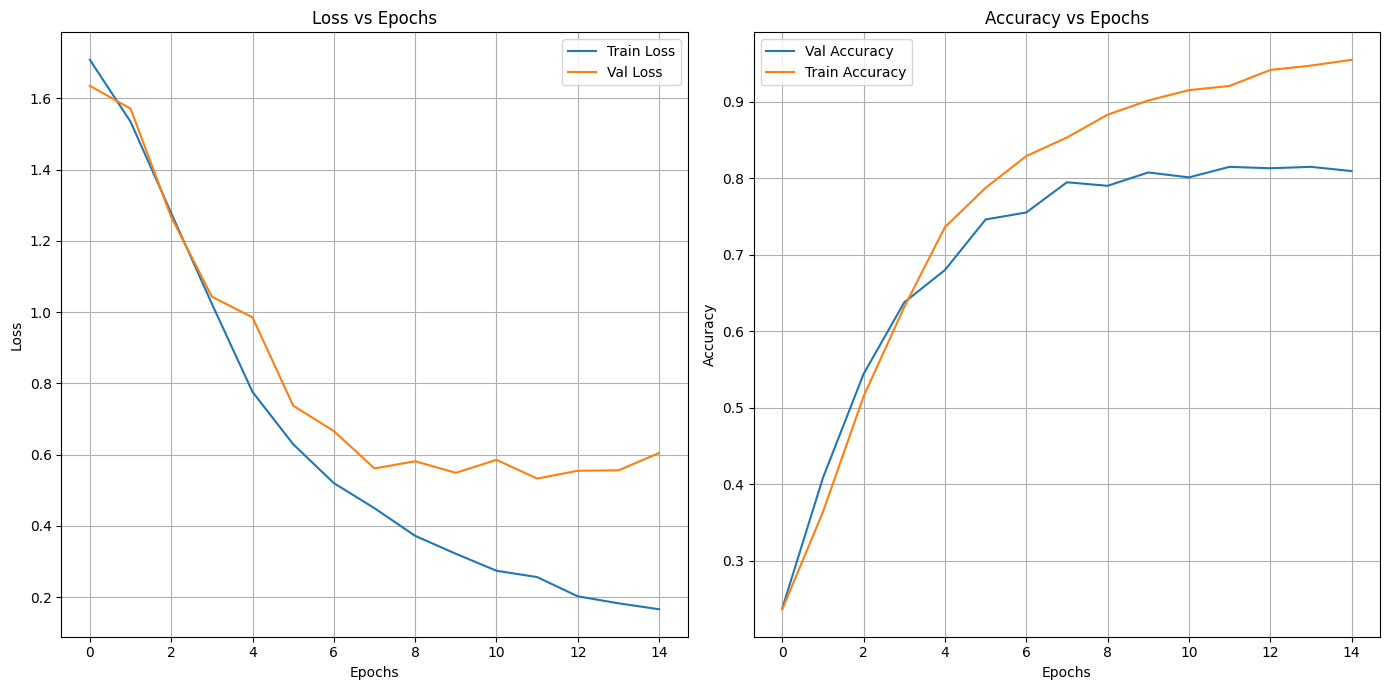

In [25]:
data = np.load('bilstm_history.npz', allow_pickle=True)
train_loss = data['train_loss']
train_acc = data['train_acc']
val_loss = data['val_loss']
val_acc = data['val_acc']

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Val Accuracy')
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## BiGRU – Approach

BiGRU (Bidirectional Gated Recurrent Unit) is another gated recurrent architecture designed to model sequential data while addressing the vanishing gradient problem seen in a basic RNN. Like the LSTM, the GRU selectively controls how information is remembered or forgotten across time. However, instead of maintaining a separate cell state, the GRU uses a **single hidden state** updated through two gates:

* **Reset Gate** – controls how much past information to discard
* **Update Gate** – replaces the separate forget and input gates from the LSTM, determining how much new information should be incorporated versus retained

This results in a simpler architecture with **fewer parameters** and **faster training**, while still capturing long-range dependencies effectively.

To ensure a fair comparison to the BiLSTM model, we **use the same hyperparameters** (hidden dimension, number of layers, dropout rate, learning rate, and batch size), and we similarly configure the GRU with:

```python
num_layers > 1, bidirectional=True
```

which gives us a **stacked bidirectional GRU**. The same **sequence packing** (`pack_padded_sequence`) is used to handle variable-length inputs so that padding does not influence the hidden state updates.

As with the BiLSTM, the GRU outputs a sequence representation `out ∈ [batch, seq_len, 2*hidden_dim]`. We tested several pooling strategies (`last`, `sum`, `mean`, `max`) and, based on validation results, **we retained max pooling** as it consistently performed best, likely because the key informative features in our classification task are captured as high-activation patterns across positions.

After pooling, we apply a dropout layer and a final fully connected layer to obtain class logits, followed by cross-entropy loss and optimization with **Adam**, using the **same early stopping criteria** for consistency with prior experiments.



In [26]:
class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5, pooling='max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if embeddings is not None:
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, text, lengths):
        embedded = self.embedding(text)  # [batch, seq_len, emb_dim]
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.gru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        if self.pooling == 'last':
            fwd = h_n[-2, :, :]
            bwd = h_n[-1, :, :]
            sent = torch.cat([fwd, bwd], dim=1)
        elif self.pooling == 'max':
            sent, _ = torch.max(out, dim=1)
        elif self.pooling == 'mean':
            sent = torch.sum(out, dim=1) / (lengths.unsqueeze(1).to(out.device))
        elif self.pooling == 'sum':
            sent = torch.sum(out, dim=1)
        else:
            raise ValueError(f"Unknown pooling: {self.pooling}")

        sent = self.dropout(sent)
        logits = self.fc(sent)
        return logits


In [27]:
# --- Hyperparameters ---
EMB_DIM = 300
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.4
POOLING = 'max'    # 'last' | 'max' | 'mean' | 'sum'

LR = 0.0001
BATCH_SIZE = 64
EPOCHS = 50
PATIENCE = 3
FREEZE_EMB = False

# --- Derive sizes from loaded pipeline ---
if 'TEXT' in globals() and 'LABEL' in globals():
    vocab_size = len(TEXT.vocab)
    num_classes = len(LABEL.vocab)
    print(f"vocab_size={vocab_size}, num_classes={num_classes}")
else:
    raise RuntimeError("TEXT/LABEL not available. Please enable Option A (load your artifacts) or Option B (torchtext pipeline).")

# --- Build model ---
emb_matrix = None
if 'pretrained_embeddings' in globals() and pretrained_embeddings is not None:
    # Ensure shape [vocab_size, EMB_DIM]
    if pretrained_embeddings.size(1) != EMB_DIM:
        raise ValueError(f"Embedding dim mismatch: got {pretrained_embeddings.size(1)} vs EMB_DIM={EMB_DIM}")
    emb_matrix = pretrained_embeddings

bigru_model = BiGRUClassifier(
    vocab_size=vocab_size,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    embeddings=emb_matrix,
    freeze_embeddings=FREEZE_EMB,
    dropout=DROPOUT,
    pooling=POOLING
)
print(bigru_model)

vocab_size=8093, num_classes=6
BiGRUClassifier(
  (embedding): Embedding(8093, 300, padding_idx=0)
  (gru): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)


In [28]:
bigru_criterion = nn.CrossEntropyLoss()
bigru_optimizer = optim.Adam(bigru_model.parameters(), lr=LR)

bigru_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
bigru_best_val_acc = -1.0
bigru_wait = 0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_loop(bigru_model, train_iter, bigru_optimizer, bigru_criterion)
    va_loss, va_acc = eval_loop(bigru_model, valid_iter, bigru_criterion)

    bigru_history['train_loss'].append(tr_loss)
    bigru_history['train_acc'].append(tr_acc)
    bigru_history['val_loss'].append(va_loss)
    bigru_history['val_acc'].append(va_acc)

    print(f"[BiGRU] Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}")

    if va_acc > bigru_best_val_acc:
        bigru_best_val_acc = va_acc
        bigru_wait = 0
        torch.save(bigru_model.state_dict(), 'bigru_best.pt')
    else:
        bigru_wait += 1
        if bigru_wait >= PATIENCE:
            print("[BiGRU] Early stopping triggered.")
            break



[BiGRU] Epoch 01 | Train Loss: 1.6529 | Train Acc: 0.2760 | Val Loss: 1.5876 | Val Acc: 0.3413
[BiGRU] Epoch 02 | Train Loss: 1.4892 | Train Acc: 0.4097 | Val Loss: 1.4795 | Val Acc: 0.4330
[BiGRU] Epoch 03 | Train Loss: 1.2677 | Train Acc: 0.5392 | Val Loss: 1.2972 | Val Acc: 0.5505
[BiGRU] Epoch 04 | Train Loss: 1.0310 | Train Acc: 0.6254 | Val Loss: 1.0945 | Val Acc: 0.6156
[BiGRU] Epoch 05 | Train Loss: 0.7735 | Train Acc: 0.7290 | Val Loss: 0.8540 | Val Acc: 0.7138
[BiGRU] Epoch 06 | Train Loss: 0.5953 | Train Acc: 0.7994 | Val Loss: 0.7237 | Val Acc: 0.7642
[BiGRU] Epoch 07 | Train Loss: 0.4816 | Train Acc: 0.8446 | Val Loss: 0.6553 | Val Acc: 0.7688
[BiGRU] Epoch 08 | Train Loss: 0.4024 | Train Acc: 0.8714 | Val Loss: 0.5596 | Val Acc: 0.7963
[BiGRU] Epoch 09 | Train Loss: 0.3520 | Train Acc: 0.8872 | Val Loss: 0.5340 | Val Acc: 0.8119
[BiGRU] Epoch 10 | Train Loss: 0.2853 | Train Acc: 0.9120 | Val Loss: 0.5501 | Val Acc: 0.8028
[BiGRU] Epoch 11 | Train Loss: 0.2534 | Train Acc:

In [29]:

bigru_model.load_state_dict(torch.load('bigru_best.pt', map_location=DEVICE))
bigru_test_loss, bigru_test_acc = eval_loop(bigru_model, test_iter, bigru_criterion)
print(f"[BiGRU] Test Loss: {bigru_test_loss:.4f} | Test Acc: {bigru_test_acc:.4f}")

bigru_topic_acc = topic_eval_loop(bigru_model, test_iter, LABEL.vocab)
print("[BiGRU] Topic-wise accuracy:")
for k, v in bigru_topic_acc.items():
    print(f"  {k}: {v:.4f}")

np.savez('bigru_history.npz',
         train_loss=np.array(bigru_history['train_loss']),
         train_acc=np.array(bigru_history['train_acc']),
         val_loss=np.array(bigru_history['val_loss']),
         val_acc=np.array(bigru_history['val_acc']))

[BiGRU] Test Loss: 0.4204 | Test Acc: 0.8960
[BiGRU] Topic-wise accuracy:
  HUM: 0.9692
  ENTY: 0.7553
  DESC: 0.9638
  NUM: 0.9027
  LOC: 0.9012
  ABBR: 0.6667


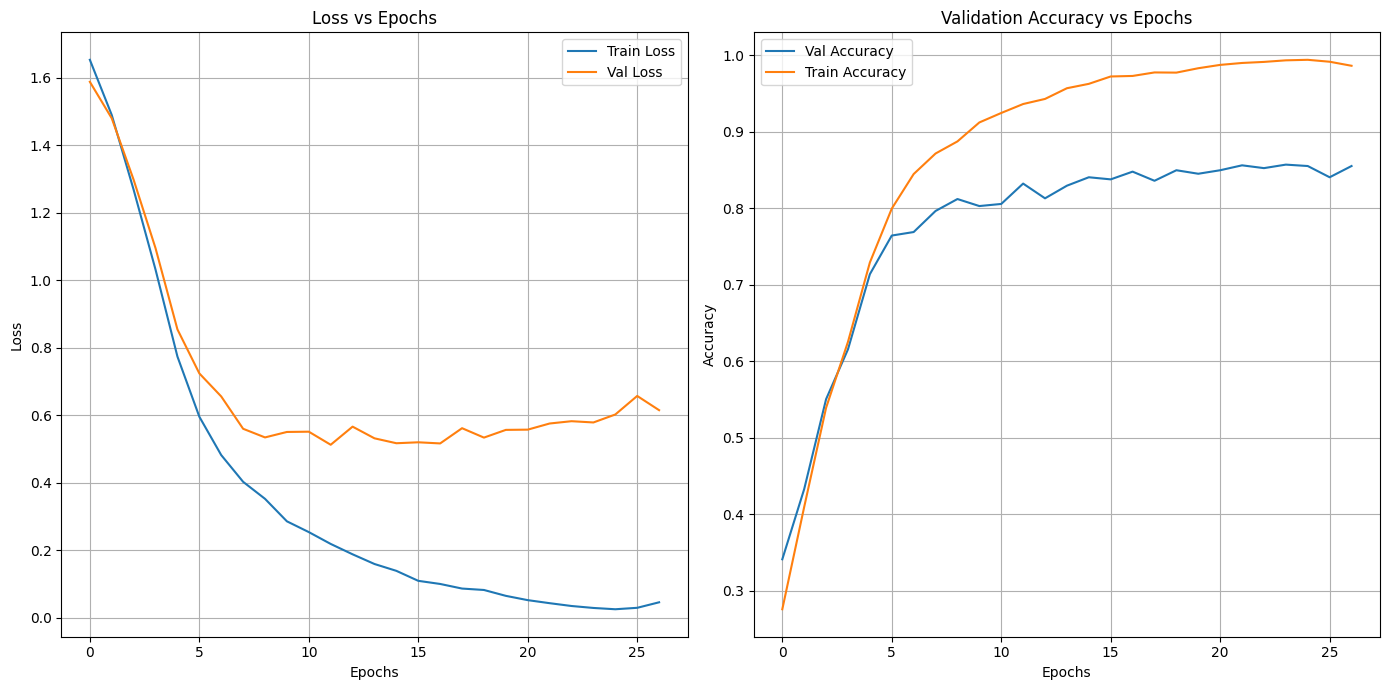

In [30]:
data = np.load('bigru_history.npz', allow_pickle=True)
train_loss = data['train_loss']
train_acc = data['train_acc']
val_loss = data['val_loss']
val_acc = data['val_acc']

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Val Accuracy')
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()